In [1]:
import numpy as np
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
X.shape, y.shape

((70000, 784), (70000,))

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [37]:
some_digit = X.loc[0].values
some_digit_image = some_digit.reshape(28,28)

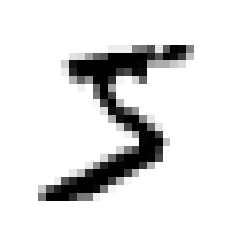

In [38]:
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [39]:
y[0]

'5'

In [42]:
y = y.astype(np.uint8)

In [44]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

In [45]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [48]:
from sklearn.linear_model import SGDClassifier

In [49]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [50]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Cross-validation

In [51]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [53]:
skfolds = StratifiedKFold(n_splits=3)

In [70]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train.iloc[train_index]
    X_test_fold   = X_train.iloc[test_index]
    y_test_fold   = y_train.iloc[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.8787
0.8495
0.85815


In [71]:
from sklearn.model_selection import cross_val_score

In [72]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [73]:
from sklearn.base import BaseEstimator

In [74]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [75]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

This gives 90% accuracy because the dataset has only 10% of iamges as 5. So, it is a skewed dataset.

## Confusion Matrix

In [77]:
from sklearn.model_selection import cross_val_predict

In [78]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [89]:
from sklearn.metrics import confusion_matrix

In [90]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [91]:
y_train_perfect_predictions = y_train_5 # pretending we reached perfection

In [92]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

precision = $ \frac{TP}{TP+FP)}$

recall /sensitivity/True Positive Rate   = $ \frac{TP}{TP + FN} $

In [93]:
from sklearn.metrics import precision_score, recall_score

In [94]:
precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred), 

(0.8370879772350012, 0.6511713705958311)

F1 score: Harmonic mean of precision and recall

F1 = $\frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2\times \frac{precision \times recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}$

* The F1 score favors classifiers that have similar precision and recall.

In [95]:
from sklearn.metrics import f1_score

In [96]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

Scikit-Learn does not let you set the threshold directly, but it does give
you access to the decision scores that it uses to make predictions. Instead of calling the classifier’s predict() method, you can call its
decision_function() method

In [97]:
y_scores = sgd_clf.decision_function([some_digit])

In [98]:
y_scores

array([2164.22030239])

In [99]:
threshold = 0

In [104]:
y_some_digit_pred = (y_scores > threshold)

In [105]:
y_some_digit_pred

array([ True])

In [106]:
threshold = 8000

In [107]:
y_some_digit_pred = (y_scores > threshold)

In [108]:
y_some_digit_pred

array([False])

How to decide what threshold to use. Use `cross_val_predict()` to get the scores of all the instances in the training set, but this time specify that we want to return decision scores instead of predictions.

In [109]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [110]:
from sklearn.metrics import precision_recall_curve

In [113]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, 
                                                         y_scores)

In [120]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.legend()

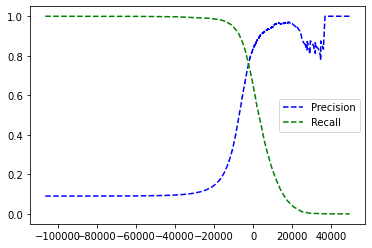

In [121]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Another way to select a good precision/recall trade-off is to plot precision directly against recall

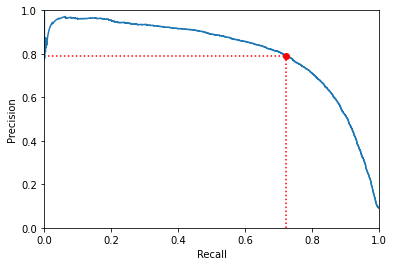

In [151]:
plt.plot(recalls, precisions)
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(recalls[55000], precisions[55000], "ro")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.vlines(recalls[55000],0,precisions[55000], "r", "dotted")
plt.hlines(precisions[55000],0,recalls[55000], "r", "dotted")
plt.show()

In [152]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]# 
# In case of multiple occurrences of the maximum values, the indice
# corresponding to the first occurrence are returned.

In [153]:
threshold_90_precision

3370.019499143958

In [159]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [160]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [161]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## ROC Curve

ROC curve plots the true positive rate (another name for recall) against the false positive rate (FPR).
The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity.

In [162]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [182]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.ylabel("TPR(Recall)")
    plt.xlabel("False Positive Rate")

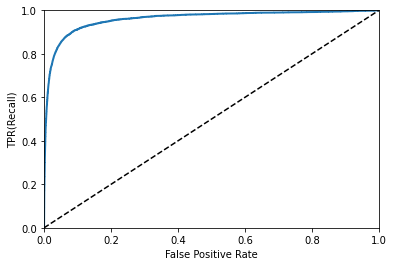

In [183]:
plot_roc_curve(fpr, tpr)
plt.show()

One way to compare classifiers is to measure the area under the curve
(AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [167]:
from sklearn.metrics import roc_auc_score

In [168]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### RandomForest

In [169]:
from sklearn.ensemble import RandomForestClassifier

In [170]:
forest_clf = RandomForestClassifier(random_state=42)

In [171]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, 
                                   n_jobs=-1 ,cv=3, method="predict_proba")

In [172]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class

In [174]:
y_scores_forest

array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06])

In [176]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, 
                                                      y_scores_forest)

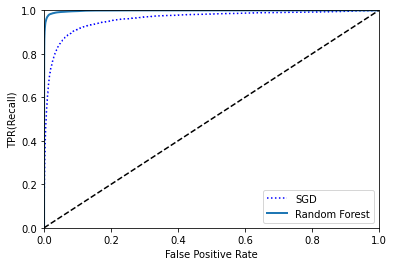

In [181]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [204]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [212]:
threshold_98_precision = thresholds_forest[np.argmax(tpr_forest >= 0.98)]

In [217]:
y_train_pred_98 = (y_scores_forest >= threshold_98_precision)

In [218]:
precision_score(y_train_5, y_train_pred_98), recall_score(y_train_5, y_train_pred_98)

(0.8605177993527509, 0.9809998155321896)

## Multiclass Classification

Scikit-Learn detects when you try to use a binary classification algorithm
for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm.

In [219]:
from sklearn.svm import SVC

In [ ]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict([some_digit])